In [10]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt

import optuna as opt
from optuna.trial import TrialState

from typing import Callable
from typing import Iterable
import re
import json
from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True, precision=3, threshold=np.inf)

# choose dataset to train
ds_num = 4

dataset_info = {
    1: ('mtb_num', 8),
    2: ('road_num', 6),
    3: ('mtb_one_hot', 53),
    4: ('road_one_hot', 49)
}

DS, INPUT_FEATURES = dataset_info[ds_num]

# choose strategy for optuna optimizer, should it maximize accurancy or minimize loss
# 1 - accurancy
# 2 - loss

opt_num = 2

opt_info = {
    1: ('maximize', 'accurancy'),
    2: ('minimize', 'loss')
}

STUDY_DIRECTION,  STRATEGY = opt_info[opt_num]

Code in this cell is done apart from train_rate function, to save some time while looking for best hyperparams with optuna
X, Y, X_test, Y_test - global variables, also will be used while **raport-making** 

In [11]:
dataset = pd.read_csv('data\\' + DS + '.csv', delimiter=',')
print(len(dataset.columns))
    
# seperate labels (price) and data
x = dataset.drop(columns=['Price', 'ID']).astype(float)
y = dataset['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# conversion from data frame do numpy matrix
x_train, x_test, y_train, y_test = map(lambda x: x.to_numpy(), [x_train, x_test, y_train, y_test])

# change of y shape from (n,) to (n,-1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# index removal (left from DF)
x_train = x_train[:,1:]
x_test = x_test[:,1:]

# conversion to tensors
X, Y, X_test, Y_test = map(lambda x: torch.tensor(x, dtype=torch.float32), [x_train, y_train, x_test, y_test]) 

52


Standard neural network with **optimizer** and **dropout** - to avoid overfitting
Function returns loss or accurancy (choosed in first cell) as score - a parameter used by **optuna** to select best values of hyperparameters 

In [12]:
def train_and_rate(trial: opt.trial.Trial, model: nn.Sequential, optimizer: optim, loss_fn: Callable, mb_size, epochs,
                   X = X, Y = Y, X_test = X_test, Y_test = Y_test):  
    
    # loss per epoch
    lpe = np.zeros(epochs)

    # proper training of nn 
    for j,epoch in enumerate(range(epochs)):
        avg_epoch_loss = 0
        for i in range(0, len(X), mb_size):
            Xbatch = X[i:i+mb_size]  
            
            # compute loss
            y_pred = model(Xbatch)
            y_batch = Y[i:i+mb_size]
            loss = loss_fn(y_pred, y_batch)
            avg_epoch_loss += loss.item() * Xbatch.size(0) # mulitply by Xbatch.size(0), because last batch can have diffrent size, so we scale loss by batch sizes 

            optimizer.zero_grad() # set grads to 0
            loss.backward()       # backprop
            optimizer.step()      # update params with optimazation 
        
        # compute lpe
        avg_epoch_loss /= len(X)  
        lpe[j] = avg_epoch_loss

        # predict prices
        with torch.no_grad():
            y_pred = model(X).detach().numpy()
            y_pred_test = model(X_test).detach().numpy()

        accurancy = (abs(y_pred_test - Y_test.numpy()) < 100).mean()

        score = avg_epoch_loss if STRATEGY == 'loss' else accurancy 

        # if trainig goes wrong optuna will prune the process
        trial.report(score, epoch)
        if trial.should_prune():
            raise opt.exceptions.TrialPruned() 
    
    # also return loss from every epoch (lpe) to plot the training process in the raport
    return score, lpe 


In [13]:
# function which will create a structure of model based on optuna suggestions
def define_model(trial):
    n_layers = trial.suggest_int("n_layers", 1, 2)
    layers = []

    in_features = INPUT_FEATURES
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 16)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.1, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, 1))

    return nn.Sequential(*layers)

In [14]:
#RMSE
def loss_fn(y_pred, y):
    loss = 0
    for y1, y2 in zip(y_pred, y):
        loss += pow(abs(y1-y2),2)
    return torch.sqrt(loss/len(y))

In [15]:
# lists that will track valuable info, will be used in raport generating
models = []
lpes = []

def objective(trial):
    model = define_model(trial)
    models.append(model)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    lr = trial.suggest_float('learning_rate', 1e-3, 1e-1)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    mb_size = trial.suggest_int('mini_batch_size', 4, 16) 
    epo = trial.suggest_int('epochs', 25, 50)
    
    lpes.append(0) # in case learining will be pruned
    score, lpe = train_and_rate(trial = trial, model = model, optimizer = optimizer, loss_fn = loss_fn, mb_size = mb_size, epochs = epo)
    lpes[-1] = lpe
    
    return score


In [16]:
study = opt.create_study(sampler=opt.samplers.TPESampler(), direction=STUDY_DIRECTION)
study.optimize(objective, n_trials=300)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))
 
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-03-08 08:53:46,684] A new study created in memory with name: no-name-b65e8a42-9960-4719-bc05-8b55f284a7ac
[I 2024-03-08 08:54:01,558] Trial 0 finished with value: 1706.8972097816663 and parameters: {'n_layers': 2, 'n_units_l0': 14, 'dropout_l0': 0.4550636124596058, 'n_units_l1': 8, 'dropout_l1': 0.3448203128423231, 'optimizer': 'Adam', 'learning_rate': 0.07240601551700923, 'mini_batch_size': 13, 'epochs': 34}. Best is trial 0 with value: 1706.8972097816663.
[I 2024-03-08 08:54:26,487] Trial 1 finished with value: 1573.045282618619 and parameters: {'n_layers': 2, 'n_units_l0': 6, 'dropout_l0': 0.441947438949697, 'n_units_l1': 13, 'dropout_l1': 0.25836285210415927, 'optimizer': 'RMSprop', 'learning_rate': 0.04041205868941999, 'mini_batch_size': 9, 'epochs': 49}. Best is trial 1 with value: 1573.045282618619.
[I 2024-03-08 08:54:49,124] Trial 2 finished with value: 1281.6177173009191 and parameters: {'n_layers': 1, 'n_units_l0': 8, 'dropout_l0': 0.19857193851046478, 'optimizer': '

Study statistics: 
  Number of finished trials:  300
  Number of pruned trials:  180
  Number of complete trials:  120
Best trial:
  Value:  1057.503374429013
  Params: 
    n_layers: 1
    n_units_l0: 16
    dropout_l0: 0.1219956259640407
    optimizer: RMSprop
    learning_rate: 0.06996036470312937
    mini_batch_size: 4
    epochs: 47


{'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.12, 'optimizer': 'RMSprop', 'learning_rate': 0.07, 'mini_batch_size': 4, 'epochs': 47}
{'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.12, 'optimizer': 'RMSprop', 'learning_rate': 0.07, 'mini_batch_size': 4, 'epochs': 47, 'plot': 'loss_plot_road_one_hot.jpg', 'td_model': '<td>{n_units_l0}</td><td>{dropout_l0}</td>', 'th_model': '<th>n units l0</th><th>dropout l0</th>', 'test100': 9.11, 'test250': 24.54, 'test500': 42.94, 'test1000': 70.26, 'train100': 11.68, 'train250': 28.43, 'train500': 48.58, 'train1000': 72.64}


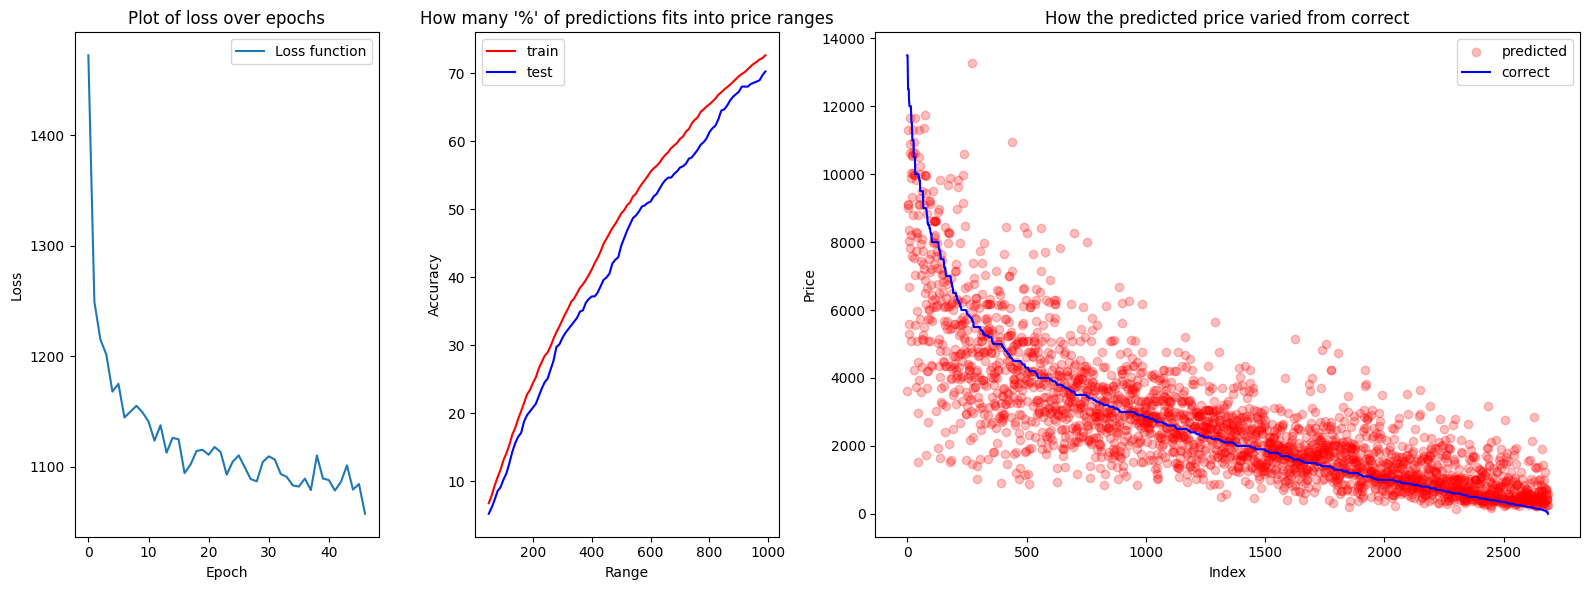

In [17]:
def generate_raport(best_trial = study.best_trial, catalog_path = 'best_models/' + DS, X = X, Y = Y, X_test = X_test, y_test = y_test):
    # get best params, model from best trial
    best_trial_params = best_trial.params
    best_model = models[best_trial.number] 

    # save model and params
    torch.save(best_model, catalog_path + '/' + STRATEGY + '_best_' + DS + '.pt')
    with open(catalog_path + '/' + STRATEGY + '_best_params_' + DS + '.json', 'w') as f:
        json.dump(best_trial_params, f, indent=4)

    # predict prices
    with torch.no_grad():
        y_pred = best_model(X).detach().numpy()
        y_pred_test = best_model(X_test).detach().numpy()

    # compute accurancy on train and test set
    accuracy_train_df = pd.Series([round((abs(y_pred - y_train) < i).mean() * 100,2) for i in range(50, 1000, 10)])
    accuracy_test_df = pd.Series([round((abs(y_pred_test - y_test) < i).mean() * 100,2) for i in range(50, 1000, 10)])
    results = pd.concat([accuracy_train_df.rename('train'), accuracy_test_df.rename('test')] ,axis=1)

    # there is no overfitting, so accurancy for final raport is going to be computed without train/test split 
    results.to_csv(catalog_path + '/' + STRATEGY + '_' + DS + '.csv', columns=['train', 'test'])

    pred_and_y_df = pd.DataFrame(data = {'y_pred': np.concatenate((y_pred, y_pred_test), axis = 0).reshape(-1), 'y': np.concatenate((y_train, y_test), axis = 0).reshape(-1)}).sort_values(by='y', ascending=False)
    
    # Utworzenie figury i układu wykresów
    fig = plt.figure(figsize=(16,6))
    from matplotlib.gridspec import GridSpec
    gs = GridSpec(1, 4, figure=fig)

    # Wykres straty
    loss = fig.add_subplot(gs[0, 0])
    loss.plot(np.arange(best_trial_params['epochs']), lpes[best_trial.number], label="Loss function")
    loss.set_xlabel("Epoch")
    loss.set_ylabel("Loss")
    loss.set_title("Plot of loss over epochs")
    loss.legend()

    # Wykres dokładności
    acc = fig.add_subplot(gs[0, 1])
    acc.plot(range(50, 1000, 10), accuracy_train_df, c='r', label = 'train')
    acc.plot(range(50, 1000, 10), accuracy_test_df, c='b', label = 'test')
    acc.set_xlabel('Range')
    acc.set_ylabel('Accuracy')
    acc.set_title("How many '%' of predictions fits into price ranges")
    acc.legend()

    # Rozszerzony wykres porównawczy
    compare = fig.add_subplot(gs[0, 2:])
    compare.scatter(range(len(pred_and_y_df['y_pred'])), pred_and_y_df['y_pred'], c='r', label = 'predicted', alpha = 0.25)
    compare.plot(range(len(pred_and_y_df['y'])), pred_and_y_df['y'], c='b', label = 'correct')
    compare.set_xlabel('Index')
    compare.set_ylabel('Price')
    compare.set_title("How the predicted price varied from correct")
    compare.legend()

    fig.tight_layout()
    fig.savefig(catalog_path + '/' + STRATEGY + '_plot_'+ DS + '.jpg')

    # generate html with raport
    n_lay = best_trial_params['n_layers']
    th_model = ''.join(["<th>n units l{}</th><th>dropout l{}</th>".format(n, n) for n in range(n_lay)])
    td_model = ''.join([f"<td>{{n_units_l{n}}}</td><td>{{dropout_l{n}}}</td>" for n in range(n_lay)])

    best_trial_params_rounded = {k: round(v, 2) if isinstance(v, (float)) else v for k, v in best_trial_params.items()}
    print(best_trial_params_rounded) 
    html_raport_dict = best_trial_params_rounded | {'plot': STRATEGY + '_plot_'+ DS + '.jpg'} | {'td_model': td_model, 'th_model': th_model} | {'test100': accuracy_test_df[4], 'test250': accuracy_test_df[19], 
    'test500': accuracy_test_df[44], 'test1000':accuracy_test_df[94]} | {'train100': accuracy_train_df[4], 'train250': accuracy_train_df[19], 'train500': accuracy_train_df[44], 'train1000':accuracy_train_df[94]}

    print(html_raport_dict)
    
    html = '''
            <table border="1">
                <thead>
                    <tr style="text-align: center;">
                        <th colspan=100%>Hyperparameters</th>
                    </tr>
                    <tr style="text-align: center;">
                        <th colspan=2>optimizer</th>
                        <th colspan=2>learning rate</th>
                        <th colspan=2>mini batch size</th>
                        <th colspan=2>epochs</th>
                    </tr>
                </thead>
                <tbody>
                    <tr>
                        <td colspan=2>{optimizer}</td>
                        <td colspan=2>{learning_rate}</td>
                        <td colspan=2>{mini_batch_size}</td>
                        <td colspan=2>{epochs}</td>
                </tbody>

                <thead>
                    <tr style="text-align: center;">
                        <th colspan="100%">Model - every model has structure: Linear -> ReLu -> Linear ...</th>
                    </tr>
                    <tr style="text-align: center;">
                        <th colspan = 1>n_layers</th>
                        {th_model}
                    </tr>
                </thead>
                <tbody>
                    <tr>
                        <td colspan = 1>{n_layers}</td>
                        {td_model}
                </tbody>
                <thead>
                    <tr style="text-align: center;">
                        <th colspan=8>Accurancy in ranges</th>
                    </tr>
                    <tr style="text-align: center;" >
                        <th colspan=4>Train</th>
                        <th colspan=4>Test</th>
                    </tr>
                </thead>
                <tbody>
                    <tr style="text-align: center;">
                        <td>100$</td>
                        <td>250$</td>
                        <td>500$</td>
                        <td>1000$</td>
                        <td>100$</td>
                        <td>250$</td>
                        <td>500$</td>
                        <td>1000$</td>
                    </tr>
                    <tr>
                        <td>{train100}%</td>
                        <td>{train250}%</td>
                        <td>{train500}%</td>
                        <td>{train1000}%</td>
                        <td>{test100}%</td>
                        <td>{test250}%</td>
                        <td>{test500}%</td>
                        <td>{test1000}%</td>
                    </tr>
                        <tr>
                        <td colspan = "100%">
                            <img src={plot}>
                        </td>
                    </tr>
                </tbody>
                </table>'''
    

    styles = '''
        <style>
        table{
            font-family: Arial, Helvetica, sans-serif;
            border-collapse: collapse;
            width: 100%;
        }
        
        table tbody td, table th {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: center;
        }

        table tr:nth-child(even){
            background-color: #f2f2f2;
            text-align: center;
        }

        table tr:hover {background-color: #ddd;}

        table th {
            padding-top: 12px;
            padding-bottom: 12px;
            text-align: center;
            color: white;
        }

        table thead tr:nth-child(1) {
            font-size: 24px;
            background-color: #80b3ff;
        }

        table thead tr:nth-child(2) {
            background-color: #ff8080;
        }
    </style>
    '''
    html = html.format_map(html_raport_dict).format_map(html_raport_dict)

    with open(catalog_path + '/' + STRATEGY + '_raport_' + DS + '.html', 'w') as f:
        f.write(styles + html)
generate_raport()

0      7.67
1      9.21
2      9.72
3     10.23
4     11.00
      ...  
90    65.73
91    65.73
92    65.98
93    66.24
94    66.24
Name: test, Length: 95, dtype: float64


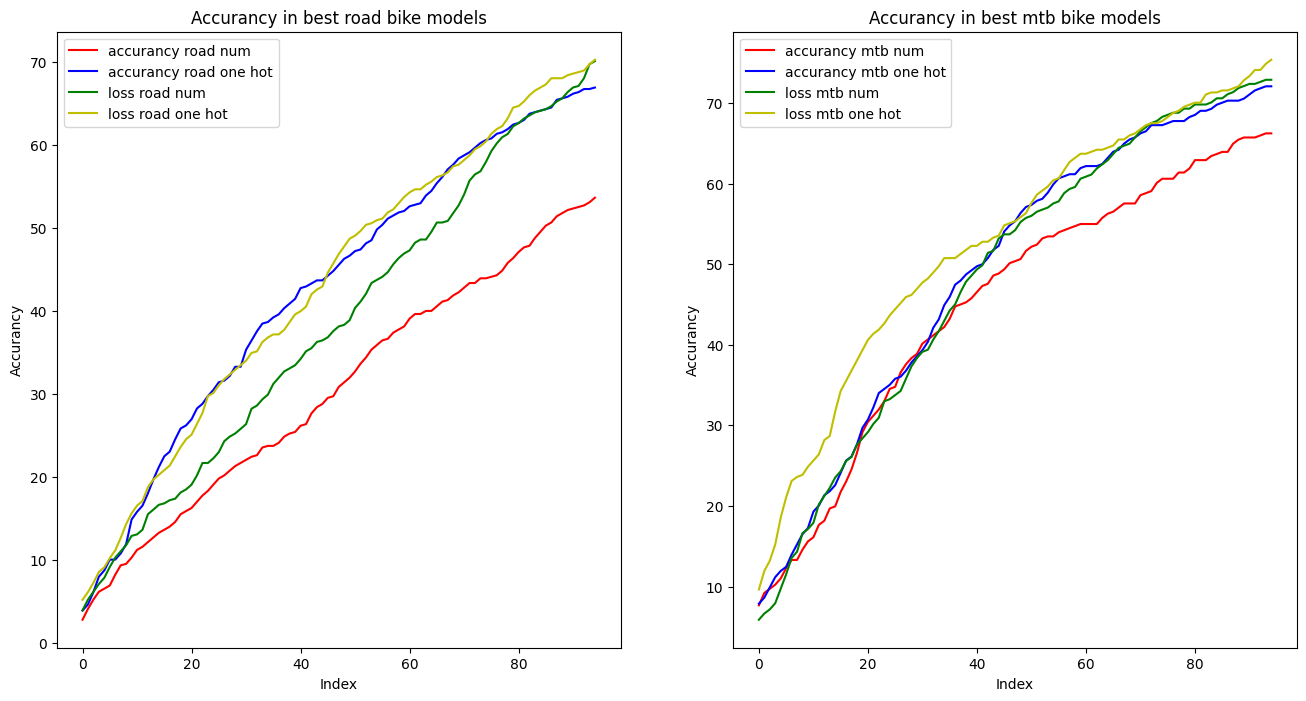

In [27]:
# plots

accurancy_mtb_num = pd.read_csv('best_models/mtb_num/accurancy_mtb_num.csv')['test']
loss_mtb_num = pd.read_csv('best_models/mtb_num/loss_mtb_num.csv')['test']
accurancy_mtb_one_hot = pd.read_csv('best_models/mtb_one_hot/accurancy_mtb_one_hot.csv')['test']
loss_mtb_one_hot = pd.read_csv('best_models/mtb_one_hot/loss_mtb_one_hot.csv')['test']
accurancy_road_num = pd.read_csv('best_models/road_num/accurancy_road_num.csv')['test']
loss_road_num = pd.read_csv('best_models/road_num/loss_road_num.csv')['test']
accurancy_road_one_hot = pd.read_csv('best_models/road_one_hot/accurancy_road_one_hot.csv')['test']
loss_road_one_hot = pd.read_csv('best_models/road_one_hot/loss_road_one_hot.csv')['test']
print(accurancy_mtb_num )

fig, (road_plot, mtb_plot) = plt.subplots(1, 2, figsize = (16,8))
    
road_plot.plot(range(len(loss_road_num)), accurancy_road_num, c = 'r', label = 'accurancy road num')
road_plot.plot(range(len(loss_road_num)), accurancy_road_one_hot, c = 'b', label = 'accurancy road one hot')
road_plot.plot(range(len(loss_road_num)), loss_road_num, c = 'g', label = 'loss road num')
road_plot.plot(range(len(loss_road_num)), loss_road_one_hot, c = 'y', label = 'loss road one hot')
road_plot.set_xlabel('Index')
road_plot.set_ylabel('Accurancy')
road_plot.set_title("Accurancy in best road bike models")
road_plot.legend()

mtb_plot.plot(range(len(loss_mtb_num)), accurancy_mtb_num, c = 'r', label = 'accurancy mtb num')
mtb_plot.plot(range(len(loss_mtb_num)), accurancy_mtb_one_hot, c = 'b', label = 'accurancy mtb one hot')
mtb_plot.plot(range(len(loss_mtb_num)), loss_mtb_num, c = 'g', label = 'loss mtb num')
mtb_plot.plot(range(len(loss_mtb_num)), loss_mtb_one_hot, c = 'y', label = 'loss mtb one hot')
mtb_plot.set_xlabel('Index')
mtb_plot.set_ylabel('Accurancy')
mtb_plot.set_title("Accurancy in best mtb bike models")
mtb_plot.legend()

fig.savefig('best_models/accurancy_general_raport.jpg')

In [ ]:
import imgkit
import os
import re

found_raports = []
for root, dirs, files in os.walk('.\\best_models'):
    for file in files:
        if file.endswith('.html'):
            found_raports.append(os.path.join(root, file))

path_to_wkhtmltoimage = "C:\\Users\\Szymon\\wkhtmltopdf\\bin\\wkhtmltoimage.exe"
config = imgkit.config(wkhtmltoimage=path_to_wkhtmltoimage)

options = {
    'format': 'jpg',
    'no-images': '',
    'disable-javascript': ''
    }

for html_file in found_raports:
    imgkit.from_file(html_file, re.sub('.html', '.jpg', html_file), config=config, options=options)